# Snowflake APAC Python VHOLS - July 2022

Welcome and thanks for joining us! 

This session is focused on:
- An initial introduction and walkthrough Snowpark - how to use it from a local perspective, and how to use it to interact with Python in Snowflake itself
- Simple connectivity, data engineering and machine learning in Snowflake
- Seeing how Snowpark can help us quickly and easily get started analysing and using data

What we're not doing today:
- Going deep on ML algorithms and training hyper-accurate models - would take too long for this session
- Building a machine learning pipeline
- Detailed Streamlit usage
- Using massive data

I'd love to run through these pieces, but they're deeper than we have time for today - especially if we try to leave room for questions! If you'd like to go deeper on these aspects, there is an excellent quickstart that we ran at the recent Snowflake Summit 2022 - you can check it out at https://quickstarts.snowflake.com/guide/machine_learning_with_snowpark_python/index.html. 

If you'd like to learn more about Streamlit, you can check out our Quickstart at https://quickstarts.snowflake.com/guide/getting_started_with_snowpark_for_python_streamlit/index.html

(I'm not using massive data because I happened to choose a relatively small dataset - this is also a little easier to manipulate for those of you working from home!)

## Agenda

Today we will be using Snowflake to (try to) build and explore a model of how weather affects pedestrian patterns in the Melbourne CBD. We'll go through the following steps:

1. Setup - getting connected to Snowflake through the Snowpark API, some basics, and double checking that our environment is workable.

2. Collecting data in my Jupyter notebook (weather data) and converting it to Snowpark.

3. Collecting data from an S3 bucket and connecting that to Snowpark.

4. Local Machine Learning using Snowpark's dataframes to prepare the data.

5. Exploration of Python UDFs - different ways of running Python code within the Snowflake parallel compute environment

6. Using a Python UDF to train my model in Snowflake

7. Using a Python UDF to run my model in Snowflake

8. Using Streamlit to connect to Snowflake and explore the model vs the actuals.

# Step 1: Setup + Connecting to Snowflake

In [ ]:
from snowflake.snowpark.session import Session
from snowflake.snowpark.functions import col, sql_expr, to_timestamp
from snowflake.snowpark.exceptions import SnowparkSQLException
from snowflake.snowpark.types import TimestampType, DecimalType, StructType, StructField
import pandas as pd
from meteostat import Point, Hourly
from datetime import datetime 
import matplotlib.pyplot as plt
import requests
import json
from pprint import pprint

In [ ]:
# fill your connection details into secrets.json - use secrets_FILL_ME_IN.json as the template
try:
    with open('./secrets.json','r') as secrets_file:
        secrets = json.load(secrets_file)
except FileNotFoundError:
    print("Please put your Snowflake connection details into a secrets.json file in the working directory.")
    
if secrets["snowflake"]["account"] == "YOUR_ACCOUNT_HERE":
    print("Please fill in the secrets into the file!")


In [ ]:
session = Session.builder.configs(secrets["snowflake"]).create()

Let's take a quick look at one of the key differences between the Snowflake Connector for Python and the Snowflake Snowpark Python methods for querying data. To start, let's use the underlying connector for the session to run a query:

In [ ]:
session._conn._conn.cursor().execute("select current_warehouse(), current_database(), current_schema()").fetchone()

Notice that the SQL is run immediately, and that it is returned (using `fetchone`, at least) immediately as a tuple. The Snowflake Connector for Python will also let us return multiple records using `fetchmany` and `fetchall`, or Pandas/Arrow dataframes using `fetch_pandas_batches`, `fetch_pandas_all`, `fetch_arrow_all`, or `fetch_arrow_batches`, but no matter what, `execute` will immediately run the statement. 

_Also note: the underscore preceeding the `_conn` objects indicates that this is a private API; while you **can** call it, you probably shouldn't, as it's not supported and might change at any time. Instead, spin up a separate connection instance from the regular Snowflake Connector for Python API if you need one._

Now, let's run the same statement, but with the Snowpark session API:

In [ ]:
session.sql("select current_warehouse(), current_database(), current_schema()")

_This didn't run._ Check your query history if you don't believe me! This is because Snowpark uses _lazy execution_, which means it won't run a query until it has to. To force the query to run so that we can check it works, we can use `collect` (or `show` if we want it nicely formatted):

In [ ]:
session.sql("select current_warehouse(), current_database(), current_schema()").collect()

In [ ]:
session.sql("select current_warehouse(), current_database(), current_schema()").show()

The following is a little bit of setup code - we need a sandbox environment in which to do our work.

In [ ]:
import re
import warnings

# convert usernames with anything that's not alphanumeric to be an underscore
safe_user = re.sub("[^0-9a-zA-Z]+",'_',secrets["snowflake"]["user"])

# create the warehouse defined in the secrets file if it didn't exist already
session.sql(f"CREATE WAREHOUSE IF NOT EXISTS {secrets['snowflake']['warehouse']} INITIALLY_SUSPENDED = TRUE;").collect()

# create the database defined in the secrets file if it didn't exist already
session.sql(f"CREATE DATABASE IF NOT EXISTS {secrets['snowflake']['database']};").collect()
session.sql(f"USE DATABASE {secrets['snowflake']['database']};").collect()

# check to see if a schema already exists for this lab - either the one defined in the secrets file, or 
# (if we have to create one), that but with the safe username appended so as not to stomp on others in the same env.
if session.sql(f"SHOW SCHEMAS;").filter((f'''upper("name")=upper('{secrets["snowflake"]["schema"]}')
                                     or (upper("name")=upper('{secrets["snowflake"]["schema"]}_{safe_user}')) '''))\
.count() == 0:
    session.sql(f'CREATE SCHEMA {secrets["snowflake"]["schema"]}_{safe_user}').collect()

try:
    session.sql(f'USE SCHEMA {secrets["snowflake"]["schema"]}').collect();
except SnowparkSQLException:
    session.sql(f'USE SCHEMA {secrets["snowflake"]["schema"]}_{safe_user}').collect()

    
# check that this all worked.
session.sql("select current_warehouse(), current_database(), current_schema()").show()

If your output looks similar to the below, you're ready to go! If you see "None" for any of the values, you need to ensure that you have either already got a Virtual Warehouse, Database and Schema that match the configurations in secrets.json, or a role with the ability to create them. 

**Note: a red ERROR is fine, so long as the output from show() is good.**

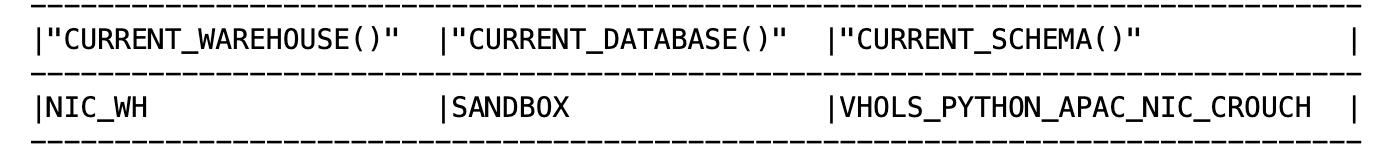


The below code checks to see if you can run Anaconda packages in your organisation. If you can't, you will need your orgadmin to perform the instructions at https://docs.snowflake.com/en/developer-guide/udf/python/udf-python-packages.html#using-third-party-packages-from-anaconda. 

In [ ]:
from snowflake.snowpark.functions import udf
try:
    # check to see if we can use Anaconda packages
    @udf(packages=["scikit-learn"], session=session)
    def check_anaconda() -> list:
        import sklearn as sk
        return [sk.__version__]

    print(session.sql('SELECT 1').select(check_anaconda()).collect())
    can_run_anaconda = True

except SnowparkSQLException:
    # cannot run anaconda packages
    print("You will need to follow the instructions at https://docs.snowflake.com/en/developer-guide/udf/python/udf-python-packages.html#using-third-party-packages-from-anaconda.")
    print("This will require Orgadmin access - if you don't have this access, contact your Snowflake administrator.")


# Step 2: Get Weather Data

We use a library here known as [meteostat](https://meteostat.net/en/), which provides data from a number of weather data sources. It's very good for quick work, but there are data quality issues. If you want a better source of data that's just as easy to get access to, it's worth checking out the providers on the [Snowflake Data Marketplace](https://www.snowflake.com/marketplace/).

In [ ]:
start = datetime(2019, 1, 1)
end = datetime(2022, 6, 30)

melbourne = Point(-37.8136, 144.9631)
melair = Hourly(94866, start, end).fetch() # Melbourne Airport

# For some reason, meteostat only grabs full years if they're available, so we get the dailies for this year also
melair2 = Hourly(94866, datetime(2022,1,1), datetime(2022,6,30)).fetch() 

melair = pd.concat([melair,melair2])

In [ ]:
melair = melair.reset_index()
melair

Now we have a _Pandas_ dataframe, but we want to work with this data in Snowflake - we need a Snowpark dataframe; the two are different! Fortunately, this is an easy conversion:

In [ ]:
melair_weather = session.create_dataframe(melair)

#### The difference between `write_pandas` and `create_dataframe`
There are two Snowpark functions that allow you to create a Snowpark object from a Pandas dataframe: `write_pandas` and `create_dataframe`. The main difference is that `write_pandas` creates a permanent table for the data to live in, while `create_dataframe`, by default, will create a temporary table that gets deleted at the end of the session. We use `create_dataframe` here for the sake of repeatability and because the amount of data is small. If the data were larger, we might consider creating a permanent table for it with `write_pandas`. 

In [ ]:
melair_weather.show()

# Step 3: Get Pedestrian Count Data

Today's session uses data from the City of Melbourne, specifically Pedestrian Counts from various pedestrian sensors around the city. To start with, we can use the below code to get the data directly from their API. I encourage you to explore this method following the lab. 

However, it's probably better for now that we don't all hit the API at once for some 500MB of data, so I've rehosted it in S3. We can use Snowflake External Stages to get that data and load it into a dataframe directly.

In [ ]:
from sodapy import Socrata
from os import path, remove
import pickle

In [ ]:
# To get an API Key for Socrata, please see: https://support.socrata.com/hc/en-us/articles/210138558-Generating-an-App-Token

# Note: this downloads approximately 300-500MB of data to the local machine. 
# If this machine is on a metered or slow connection, please set METERED_CONNECTION to True. 
# You will skip downloading the data locally, but this is not required for the rest of the lab.

# This data is made available under CC BY 4.0 by the City of Melbourne from 
# https://data.melbourne.vic.gov.au/Transport/Pedestrian-Counting-System-Monthly-counts-per-hour/b2ak-trbp

METERED_CONNECTION = True

if not METERED_CONNECTION:
    client = Socrata("data.melbourne.vic.gov.au", secrets['socrata']['app_key'])
    file_name = 'melbourne_pedestrian_counts.pkl'


    if not path.isfile(f'./{file_name}'):
        results = list(client.get_all("b2ak-trbp",limit=50000, where="date_time >= '2019-01-01T00:00:00'"))
        try:
            with open(f'./{file_name}', 'wb') as pkl:
                pickle.dump(results, pkl)
        except:
            remove(f'./{file_name}')
            raise
    else:
        with open(f'./{file_name}', 'rb') as pkl: 
            results = pickle.load(pkl)



We could convert the above to a Pandas or Snowpark dataframe relatively easily, but that would require everyone in the lab hitting the Socrata API endpoint at once, which is probably not very friendly and would make you all wait for a 500MB download. Instead, this data is available on S3; let's put it straight into Snowflake from there, using a `stage` object.

In [ ]:
session.sql("CREATE STAGE IF NOT EXISTS python_vhols url='s3://melbourne-cc-pedestrian-counts-json' file_format = (type=JSON STRIP_OUTER_ARRAY=TRUE)").collect()


The data in this stage is JSON data, let's take a look:

In [ ]:
pedestrian_counts = session.read.option("STRIP_OUTER_ARRAY", True).json("@python_vhols")

That was fast! Except... it didn't run! Remember: lazy execution!

In [ ]:
pedestrian_counts.show()

Now we have data from a stage in my dataframe, let's transform it into tabular data, and put it into a table for later use:

In [ ]:
def cast_check(value):
    try:
        datetime.strptime(value+"000","%Y-%m-%dT%H:%M:%S.%f")
        return "::timestamp"
    except:
        pass
    try:
        float(value)
        return "::decimal"
    except:
        pass
    return ""

# 1. Get the first record from Snowflake. 
column_headers = list(json.loads(pedestrian_counts.limit(1).collect()[0]['$1']).items())

# 2. Pretty print it so that we can see it - notice everything is a string; this is an issue in source.
pprint(column_headers)

# 3. Use the cast_check method above to generate the right casts for each column.
pedestrian_counts = pedestrian_counts.select([sql_expr(f"$1:{x}{cast_check(y)} {x}") for x,y in column_headers])

In [ ]:
pedestrian_counts.show()

This is kind of ugly, but luckily, it's very easy to bring it back into Pandas for pretty display:

In [ ]:
pedestrian_counts.limit(10).to_pandas()

Now I have my transform the way that I want it, I can write this to a table of its own:

In [ ]:
pedestrian_counts.write.mode("overwrite").save_as_table("pedestrian_counts")

In [ ]:
session.table("pedestrian_counts").count()

And that's it! I've loaded my pedestrian counts from a stage into a Snowflake table.

# Step 4: Simple ML

We're now going to build an _exceedingly simple_ model based on Scikit Learn's Linear Regression model. Scikit Learn is not the only machine learning / AI package supported in Snowflake, however - it's just one of many. The full list can be found at the [Anaconda Snowpark Channel](https://repo.anaconda.com/pkgs/snowflake/), and include:

- Spacy (Natural Language Processing)
- Keras
- Tensorflow
- XGBoost
- Pytorch

In [ ]:
from sklearn import linear_model

The first thing I need to do is get the pedestrian counts from the table I created earlier. Let's start by looking at just one sensor's worth of data. 

In [ ]:
melb_central = session.table("pedestrian_counts").filter(col("sensor_name") == "Melbourne Central-Elizabeth St (East)")

In [ ]:
melb_central.limit(10).to_pandas()

Now, let's join this data to the weather details from Melbourne Airport.
Notice we join _dataframes_ here. Although in this instance they're very similar to tables, this makes it easy to join dataframes that have a heavy set of transformations applied.

In [ ]:
joined = melb_central.join(melair_weather, 
                           ((to_timestamp(melair_weather.col('"time"'),6))==melb_central.col("date_time")))

In [ ]:
joined.limit(10).to_pandas()

This is a little unwieldy - let's cut down to only the columns we need to train with.

In [ ]:
joined = joined.select(col('hourly_counts'), col('time'), col('"temp"'), col('"dwpt"'), col('"rhum"'), col('"wspd"'))

Now, let's convert the dataframe to a Pandas dataframe for use in training

In [ ]:
pd_joined = joined.to_pandas()

In [ ]:
pd_joined

Finally, let's use half the dataset as a training set and the other half for testing:

In [ ]:
y = pd_joined["HOURLY_COUNTS"]
x = pd_joined.copy().drop("HOURLY_COUNTS",axis=1)
x_training = x[:38712//2]
x_test = x[38712//2:]
y_training = y[:38712//2]
y_test = y[38712//2:]

In [ ]:
from sklearn import linear_model
regr = linear_model.LinearRegression()

In [ ]:
regr.fit(x_training.to_numpy(), y_training.to_numpy())

In [ ]:
y_pred = regr.predict(x_test.to_numpy())


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
print("Coefficients: \n", regr.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))

### To be clear, this is not a great model.
There are a number of potential reasons this is bad, including the COVID-19 related lockdowns that happened in Melbourne throughout the training period. For now, let's move on and deploy version 0.1. 

## Parallelising the training
Snowpark goes beyond simply allowing us to run Snowflake's functions in dataframes - we can define our own as well. These work as UDFs in the Snowflake engine. This will allow us to take the code we've run above and deploy it to Snowflake rather than running it locally, which means we can parallelise it using Snowflake's virtual warehouses. 

There are a couple of ways to create Python User Defined Functions (UDF) from Snowpark - let's start by looking through them.

### Temporary Anonymous  (Session Local) UDFs
Here we create a temporary session-local UDF (similar to a temporary table) that you can call from here, but you won't be able to use it later. Best for testing or very quick elements that you won't want later. Note that it's best practice, but not _required_, to set the session variable as you can see below. Otherwise, if you have multiple sessions active, you're essentially asking Snowpark to guess which one to add it to - this doesn't work and will throw an exception. In a notebook environment like this one, this is most likely to occur when you have the notebook open for a long time and the Snowflake session times out so you have to re-authenticate it. Ask me how I know.

In [ ]:
from snowflake.snowpark.functions import udf
from snowflake.snowpark.types import StringType

In [ ]:
# This implementation of pig latin is, er, non-traditional. Don't worry about it.

pig_latin = udf(lambda x: ' '.join([y[-2:]+y[:-2]+'ay' for y in x.split()]), 
                return_type=StringType(), input_types=[StringType()], session=session)

A couple of things to take note of - one, I use a lambda function here, but that's not necessary; we can use any type of Python function just fine. Two, we must define the return type, and the input types. As this is a _scalar_ UDF, there is only one return type - we'll come back to this later. 

In [ ]:
session.table("pedestrian_counts").select(pig_latin('"SENSOR_NAME"').as_("ORSENSAY_MENAY")).show()

You can also use the `UDFRegistration` class as below. Note that this is basically the same as using the `udf` function, but you set the session in the instance creation of `UDFRegistration`.

In [ ]:
from snowflake.snowpark.udf import UDFRegistration

pig_latin2 = UDFRegistration(session=session).register(func = lambda x: ' '.join([y[-2:]+y[:-2]+'ay' for y in x.split()]), 
                             return_type=StringType(), input_types=[StringType()])

session.table("pedestrian_counts").select(pig_latin2('"SENSOR_NAME"').as_("ORSENSAY_MENAY")).show()

Last but not least, you can use a decorator and Python 3 type hints to define a udf. Very pythonic!

In [ ]:
@udf(session=session)
def pig_latin3(x: str) -> str:
    return ' '.join([y[-2:]+y[:-2]+'ay' for y in x.split()])

session.table("pedestrian_counts").select(pig_latin3('"SENSOR_NAME"').as_("ORSENSAY_MENAY")).show()

### Named UDFs
Side note: you can also create a session-local named UDF by _not_ setting `is_permanent=True`. This allows you to use the UDF by name if you need to (eg. in direct SQL calls) but without having it stick around. We won't spend any time on that here, but you can if you want to. 


Note that for a named, permanent UDF, you must supply a stage for us to upload a representation of your code to. The code will live here, so for long term use you probably want to organise this better than we are here. (We'll come back to the "keeping the code in an internal stage" part soon.)

In [ ]:
# We use a table stage here for convenience, but I *don't* recommend that for anything other than very short term use!
@udf(session=session, is_permanent=True, name="pig_latin", stage_location="@%pedestrian_counts", replace=True)
def pig_latin3(x: str) -> str:
    return ' '.join([y[-2:]+y[:-2]+'ay' for y in x.split()])

session.sql('SELECT pig_latin(SENSOR_NAME) FROM pedestrian_counts').show()

### Vectorised UDFs
Vectorised (or _vectorized_, if you're following our American spelling) UDFs let you build UDFs that operate over Pandas Dataframes rather than over individual records. This can be _significantly_ faster, particularly for prediction algorithms, but it also means you can easily use algorithms that were built to use dataframes. 

You create these in the same way you create regular UDFs, but with dataframes or series as the input and return data types. Note the use of the "max_batch_size" parameter, which we use to make sure that the UDF returns within 60s (a hard time-out). 

For more info on the Python UDF Batch API, or Vectorised UDF execution, see: https://docs.snowflake.com/en/developer-guide/udf/python/udf-python-batch.html

In [ ]:
from snowflake.snowpark.types import PandasSeries

@udf(session=session, max_batch_size=1000)
def pig_latin_series(series: PandasSeries[str]) -> PandasSeries[str]:
    return series.apply(lambda x: ' '.join([y[-2:]+y[:-2]+'ay' for y in x.split()]))


#Note: this also works if you use the pd.DataFrame or pd.Series types. 

In [ ]:
session.table("pedestrian_counts").select(pig_latin_series('"SENSOR_NAME"').as_("ORSENSAY_MENAY")).show()

### User Defined Table Functions

Last but not least, Python Snowpark also allows you to define User Defined Table Functions. This is a little bit more involved, but _very_ powerful, as with a User Defined Table Function we can control how data is partitioned and passed into the function. To build a UDTF, we need a class with three methods (one non-optional, two optional):
1. An `__init__` method that optionally initializes the stateful processing of input,
2. A `process` method that processes each row,
3. An `end_partition` method that finalises processing of each input partition. 

A UDTF is _partition-aware_ if it implements the `__init__` and `end_partition` methods. 

You might see where we're going with this - let's go back to parallelising our training algorithm!

In [ ]:
from snowflake.snowpark.types import StructField, StructType, StringType, IntegerType, FloatType, BinaryType 
from snowflake.snowpark.functions import udtf, table_function
from snowflake.snowpark.exceptions import SnowparkSQLException


# Create an internal stage if we don't have one - this holds our code.
session.sql(f"CREATE STAGE IF NOT EXISTS {safe_user}_stg").collect()

# Tell Snowflake what the outputs of this UDTF are (this is referenced in the @udtf decorator below)
output_schema = StructType([
        StructField("sid", IntegerType()),
        StructField("model", BinaryType())
    ])

# Use the UDTF decorator to mark this as a Snowflake Python UDTF
@udtf(output_schema=output_schema, 
      is_permanent=True, 
      stage_location=f'{safe_user}_stg',
      replace=True,
      packages=("numpy", "scikit-learn", "pandas","munch"),
      name="linear_regression_trainer_udtf",
      session=session)
class linear_regression_trainer:
    def __init__(self) -> None:
        # we perform initialisation here - simple.
        self.x = []
        self.y = []
        self.sensor_id = None
    
    
    def process(self, hourly_counts: int, hour: int, temp: float, dwpt: float, rhum: float, wspd: float, sensor_id:int) -> list:
        # The process method is fairly small here; the actual work is done in end_partition.
        # The key is that we store all the data in memory as a list that end_partition will convert to a 
        # numpy array and pass to scikit.
        if self.sensor_id is not None and self.sensor_id != sensor_id:
            raise Exception("Must partition on sensor_id.")
        if self.sensor_id is None:
            self.sensor_id = sensor_id
        self.y.append(hourly_counts)
        self.x.append([hour, temp, dwpt, rhum, wspd])
        return None
        
    def end_partition(self) -> tuple:
        # Here we take the data we collected with process(), convert it to a numpy array and then use it
        # to train a linear regression model. Then we dump the model to a Pickle, which we can store in a 
        # Binary column in Snowflake. 
        import numpy as np
        from sklearn import linear_model
        import pickle
        x_arr = np.array(x)
        y_arr = np.array(y)
        regr = linear_model.LinearRegression()
        regr.fit(x_arr, y_arr)
        
        return ((self.sensor_id, pickle.dumps(regr)),)
        
        


**To summarise:** the above will take data that has been partitioned by Sensor ID and use it to train a set of models - one model per sensor ID - using Snowflake's parallel compute. There are some limitations to this approach:

1. Because we store the data in a Snowflake column, we are limited to the 16MB limit on 

In [ ]:
from snowflake.snowpark.functions import lit
lrt = table_function("linear_regression_trainer_udtf")
#recall that joined is only over one sensor_id
joined.join_table_function(lrt(joined["HOURLY_COUNTS"], joined["TIME"], joined['"temp"'], 
                               joined['"dwpt"'], joined['"rhum"'], joined['"wspd"'], lit(1))).show()


Ok, we've now run the table function for _one_ sensor id - let's see how to parallelise it. To start with, we'll need an unfiltered dataframe, then we'll partition it by sensor id, and order by date_time within the partition. 

In [ ]:
ped_counts = session.table("pedestrian_counts")
joined = ped_counts.join(melair_weather, ((to_timestamp(melair_weather.col('"time"'),6))==ped_counts.col("date_time")))
joined = joined.filter(joined["date_time"]<datetime(2021,1,1))

In [ ]:
joined_lrt = (joined.join_table_function(
    lrt(joined["HOURLY_COUNTS"], 
        joined["TIME"], 
        joined['"temp"'], 
        joined['"dwpt"'], 
        joined['"rhum"'], 
        joined['"wspd"'], 
        joined["sensor_id"])
                           .over(partition_by="sensor_id", order_by="date_time"))
    .select(col("model"), col("sid")))


In [ ]:
joined_lrt.write.mode("overwrite").save_as_table("pedestrian_models")


In [ ]:
grouped = session.table("pedestrian_models").group_by("SID").count()
grouped.sort(col("COUNT").desc()).show()

### Leveraging the models
Now we need to leverage the models that we just built, one per sensor ID. This is a perfect time to leverage the vectorised processing we mentioned earlier. As our models are sitting within a single column in our pedestrian models table, we can join that to our pedestrian count table and leverage it in a vectorised process, or we can write another UDTF. Performance-wise, these two options are probably similar at this scale but may differ depending on the number of sensor-ids (ie. partitions) and how well the data is sorted. Let's go ahead and write it as a vectorised UDF. 

In [ ]:
import pandas as pd
import numpy as np
from snowflake.snowpark.types import PandasSeries, PandasDataFrame

@udf(session=session, max_batch_size=10000, 
     name="linear_regression_predictor", is_permanent=True, replace=True, stage_location="@%pedestrian_counts",
    packages=["numpy","pandas","scikit-learn", "dill", "munch"])
def linear_regression_predictor(sid: PandasSeries[int], model: PandasSeries[bytes],
                               time: PandasSeries[float], temp: PandasSeries[float],
                               dwpt: PandasSeries[float], rhum: PandasSeries[float],
                               wspd: PandasSeries[float]) -> PandasSeries[float]:
    import dill
    import munch
    import numpy as np
    import pandas as pd
    # link the models to the sensor ids
    models = pd.DataFrame({"sid":sid, "model":model}).drop_duplicates()
    
    # unpickle the model back into a Python object
    models["unpickled"] = models["model"].apply(lambda x: dill.loads(x))
    
    # group the data by sensor ID
    data = pd.DataFrame({"sid":sid, "time":time, "temp":temp, "dwpt":dwpt, "rhum":rhum, "wspd":wspd}).groupby("sid")
    preds = []
    for sid_group in data.groups:
        df = data.get_group(sid_group)
        # get the relevant model
        regr = models[models["sid"]==sid_group]["unpickled"].iloc[0]
        # predict!
        prediction = (regr.predict(df.drop("sid", axis=1).to_numpy()))
        preds.append(prediction)
    return pd.Series(np.concatenate(preds))



To test that this is being called correctly, we can set up a model for which we know the outputs:

In [ ]:
output_schema = StructType([
        StructField("sid", IntegerType()),
        StructField("model", BinaryType())
    ])


@udtf(output_schema=output_schema, 
      is_permanent=True, 
      stage_location=f'{safe_user}_stg',
      replace=True,
      packages=("numpy","munch", "dill"),
      name="static_model_udtf",
      session=session)
class StaticModel:
    def __init__(self) -> None:
        self.sensor_id = None    
    
    def process(self, hourly_counts: int, hour: int, temp: float, dwpt: float, rhum: float, wspd: float, sensor_id:int) -> list:
        if self.sensor_id is not None and self.sensor_id != sensor_id:
            raise Exception("Must partition on sensor_id.")
        if self.sensor_id is None:
            self.sensor_id = sensor_id
        return None
        
    def end_partition(self) -> list:
        from munch import Munch
        import numpy as np
        import dill
        x = Munch() 
        x.predict = lambda arr: np.sum(arr, axis=1)
        return ((self.sensor_id, dill.dumps(x)),)
    
        

In [ ]:
static_model = table_function("static_model_udtf")

In [ ]:
joined_test_models = (joined.join_table_function(
    static_model(joined["HOURLY_COUNTS"], 
        joined["TIME"], 
        joined['"temp"'], 
        joined['"dwpt"'], 
        joined['"rhum"'], 
        joined['"wspd"'], 
        joined["sensor_id"])
                           .over(partition_by="sensor_id", order_by="date_time"))
    .select(col("model"), col("sid")))
joined_test_models.write.mode("overwrite").save_as_table("test_model")

In [ ]:
session.table("test_model").show()

In [ ]:
joined_test = session.table("test_model").join(joined.drop("HOURLY_COUNTS"),col("sensor_id") == col("sid"))


In [ ]:
joined_test = joined_test.select(col('sid'),
                                 col('model'), 
                                 col('time'), 
                                 col('"temp"'), 
                                 col('"dwpt"'), 
                                 col('"rhum"'), 
                                 col('"wspd"')).sort('sid')

In [ ]:
joined_test.show()

In [ ]:
from snowflake.snowpark.functions import call_udf, count

# Pass in the SID and 4 1s, so the output should always be SID+4.
joined_test.select(col("sid"),call_udf("linear_regression_predictor", 
                                         [col("sid"), col('model'), col("sid"),lit(1.0), lit(1.0),lit(1.0), lit(1.0)])
                                         .as_("predict")).write.mode("overwrite").save_as_table("test_results")
# make sure we have results
session.table('test_results').show()

# find any time we got multiple results for the same SID (would indicate the partitioning is wrong)
joined_test_multiple_count = (session.table('test_results').distinct()
     .group_by("SID")
     .count()
     .filter(col("count")>1)
     .show())

# find any time we got a wrong result
joined_test_wrong = session.table('test_results').filter(col("SID")+lit(4) != col("PREDICT")).show()

This looks good! So now, let's go ahead and apply it with the real models!

In [ ]:
ped_counts = session.table("pedestrian_counts")

joined = ped_counts.join(melair_weather, 
                         ((to_timestamp(melair_weather.col('"time"'),6))==ped_counts.col("date_time")))

joined = joined.filter(joined["date_time"]>datetime(2021,1,1)) #this has been flipped from < to >

predictions = session.table("pedestrian_models").join(joined.drop("HOURLY_COUNTS"),col("sensor_id") == col("sid"))

predictions.select(col("sid"),col("date_time"), call_udf("linear_regression_predictor", 
                                         [col("sid"),
                                          col('model'), 
                                          col('time'), 
                                          col('"temp"'), 
                                          col('"dwpt"'), 
                                          col('"rhum"'), 
                                          col('"wspd"')])
                                         .as_("predict")).write.mode("overwrite").save_as_table("predictions")
session.table('predictions').show()

In [ ]:
predictions = session.table('predictions')
predictions_actuals = (predictions.join(ped_counts, 
                                       (predictions["SID"]==ped_counts["sensor_id"]) & 
                                       (predictions["DATE_TIME"]==ped_counts["DATE_TIME"])))
predictions_actuals.limit(10).to_pandas()

# Exploration in Streamlit

Streamlit is a tool that lets us very quickly and easily create data driven applications in Python. Let's very quickly take a look at what we can do with it. 

In [ ]:
%%writefile ./__init__.py

pass

In [ ]:
%%writefile ./part_2.py

# Stub file. We'll come back to this.

def run_part_2(session):
    pass

In [ ]:
%%writefile ./main.py

import streamlit as st
from snowflake.snowpark import Session
from snowflake.snowpark.functions import col
from snowflake.snowpark.exceptions import SnowparkSQLException
from part_2 import run_part_2
import json
import re
import warnings

# fill your connection details into secrets.json - use secrets_FILL_ME_IN.json as the template
try:
    with open('./secrets.json','r') as secrets_file:
        secrets = json.load(secrets_file)
except FileNotFoundError:
    print("Please put your Snowflake connection details into a secrets.json file in the working directory.")
    
if secrets["snowflake"]["account"] == "YOUR_ACCOUNT_HERE":
    print("Please fill in the secrets into the file!")

st.set_page_config(
     page_title="Ex-stream-ly Cool App",
     page_icon="❄️",
     layout="wide",
 )  
    

session = Session.builder.configs(secrets["snowflake"]).create()

safe_user = re.sub("[^0-9a-zA-Z]+",'_',secrets["snowflake"]["user"])
session.sql(f"CREATE WAREHOUSE IF NOT EXISTS {secrets['snowflake']['warehouse']} INITIALLY_SUSPENDED = TRUE;").collect()
session.sql(f"CREATE DATABASE IF NOT EXISTS {secrets['snowflake']['database']};").collect()
session.sql(f"USE DATABASE {secrets['snowflake']['database']};").collect()
if session.sql(f"SHOW SCHEMAS;").filter((f'''upper("name")=upper('{secrets["snowflake"]["schema"]}')
                                     or (upper("name")=upper('{secrets["snowflake"]["schema"]}_{safe_user}')) '''))\
.count() == 0:
    session.sql(f'CREATE SCHEMA {secrets["snowflake"]["schema"]}_{safe_user}').collect()

try:
    session.sql(f'USE SCHEMA {secrets["snowflake"]["schema"]}').collect();
except SnowparkSQLException:
    session.sql(f'USE SCHEMA {secrets["snowflake"]["schema"]}_{safe_user}').collect()

st.title("Pedestrian count predictions")
st.write(session.table("pedestrian_counts").select(col("sensor_id"), col("sensor_name")).distinct().sort(col("sensor_id")).to_pandas())

run_part_2(session)

### THIS IS NOT A GOOD WAY TO RUN (or develop for) STREAMLIT!
I cannot emphasize this enough - we do it here only so that I don't have to mess around screensharing different windows. _You_ should open up a terminal window and execute `streamlit run main.py` there. I had no fewer than 8 zombie streamlit processes running in the background because this is suboptimal (and I forgot to run the kill command). 

When you're writing streamlit code, it is much easier to use a text editor (such as Sublime Text or VS Code) or an IDE (like PyCharm) than it is to use %%writefile as we do above. Streamlit will even hot reload code for you so you don't have to re-run the execution each time - it's really cool. 

In [ ]:
%%script sh --bg --proc streamlit_process --err streamlit_err --out streamlit_out
streamlit run main.py

In [ ]:
streamlit_process.kill()

## Visualising our models
Let's add a way we can visualise our (beautiful, faultless) models vs the actuals. To start, we want to have a way to select the sensor we're interested in.

In [ ]:
%%writefile ./part_2.py

import streamlit as st
from snowflake.snowpark.functions import col
from snowflake.snowpark.exceptions import SnowparkSQLException
import datetime

def run_part_2(session):
    sensors = session.table("pedestrian_counts").select(col("sensor_id"), col("sensor_name")).sort(col("sensor_id")).distinct()
    chosen_sensor = st.selectbox("Select a sensor:",sensors.collect(), format_func = lambda x: x["SENSOR_NAME"])
    st.write(chosen_sensor)

Now, we can use Snowpark to get the data, and display it with `st.line_chart`.

In [ ]:
%%writefile -a ./part_2.py
    
    chosen_sensor_actuals = session.table("pedestrian_counts").filter(col("sensor_id")==chosen_sensor["SENSOR_ID"]).select(col("HOURLY_COUNTS"), col("date_time")).sort("date_time")
    chosen_sensor_predictions = session.table("predictions").filter(col("sid")==chosen_sensor["SENSOR_ID"]).select(col("predict"), col("date_time")).sort("date_time")
    st.line_chart(data=chosen_sensor_actuals.to_pandas().set_index("DATE_TIME"))
    st.line_chart(data=chosen_sensor_predictions.to_pandas().set_index("DATE_TIME"))

It would be nice if we could filter the data down - let's do that with a slider:

In [ ]:
%%writefile -a ./part_2.py
    date_filter = st.slider("Filter by date:", min_value=datetime.date(2020,1,1), max_value=datetime.date(2022,6,1), value=(datetime.date(2020,1,1),datetime.date(2022,6,1)))
    chosen_sensor_actuals = session.table("pedestrian_counts").filter(col("sensor_id")==chosen_sensor["SENSOR_ID"]).select(col("HOURLY_COUNTS"), col("date_time")).sort("date_time").filter(col("date_time").between(date_filter[0], date_filter[1]))
    chosen_sensor_predictions = session.table("predictions").filter(col("sid")==chosen_sensor["SENSOR_ID"]).select(col("predict"), col("date_time")).sort("date_time").filter(col("date_time").between(date_filter[0], date_filter[1]))
    st.line_chart(data=chosen_sensor_actuals.to_pandas().set_index("DATE_TIME"))
    st.line_chart(data=chosen_sensor_predictions.to_pandas().set_index("DATE_TIME"))